# Sierpinski's carpet (Programmable logic)

This notebook will look at creating Sierpinski's carpet, which is a fractal that works by dividing a square into 9 segments and removing the middle one. This process is then carried out recursively. 

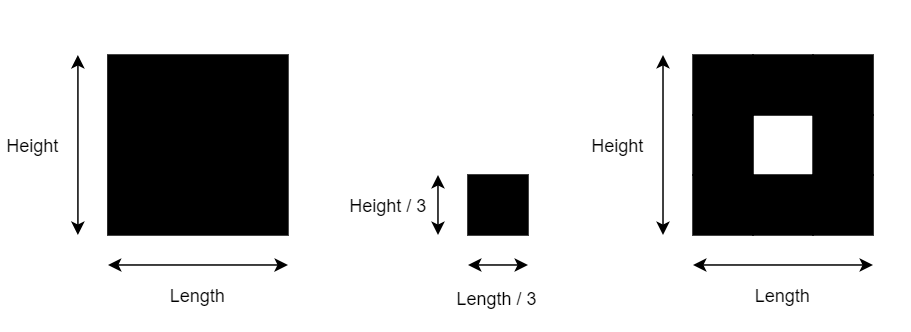

NOTE: This Notebook makes use of the resizer IP, as seen in the Pynq community example "Hello world resizer". See refrences in final cell

# Import libraries

In [1]:
from ipywidgets import *
from PIL import Image, ImageDraw, ImageEnhance, ImageColor
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay

# Download resizer IP bitsream

In [2]:
resize_design = Overlay(
    "../bitstream/resizer.bit")

Create DMA and Resizer IP objects

In [3]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0

# Create an Image object using PIL in SW

The square image is loaded from the folder and create a PIL image object

In [4]:
image_path = "images/square.png"
original_image = Image.open(image_path)
original_image.load()

# Create pixel array

The following line is used to tell Jupyter that the image should only be 3 components wide. All components holds the same data. We select the first three components.

Numpy is used to create the array of pixels

In [5]:
input_array = np.array(original_image)[:,:,0:3]

# Display original image

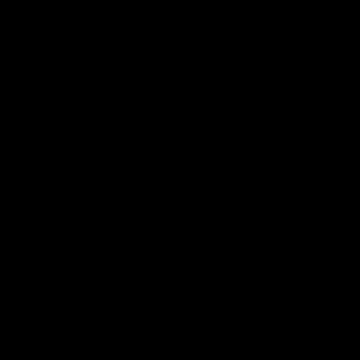

In [6]:
input_image = Image.fromarray(input_array)
display(input_image)

Note the dimensions of the original image, as the final fractal should also be this size

In [7]:
old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))

Image size: 360x360 pixels.


In [8]:
xlnk = Xlnk()   

In [9]:
resizer.write(0x00,0x00) # reset IP

# Create slider 

A slider is created so the user can select the number of iterations they want to execute for the fractal.
To operate the slider run this cell then select desired number. 

In [10]:
def update(limit):
    
    limit = limit
    
    

limit=widgets.IntSlider(min=1,max=10,step=1)

interact(update, limit=limit);

interactive(children=(IntSlider(value=1, description='limit', max=10, min=1), Output()), _dom_classes=('widget…

We now cast the slider limit value to an integer, this way it can be used for the number of times the for loop executes

In [11]:
limitIntValue = int(limit.value)

# Create Sierpinski's carpet

A for loop executes the recursion, depending on how many iterations are selected from the slider. 

The box variables are a tuple that sets the co-ordinates of the resized images. We then paste these boxes to the original image to create our fractal.

As this is the Sierpinski carpet we need to remove the middle square as mentioned previously. To do this we use a white fill on the middle box. 

In [12]:
for n in range(limitIntValue):
           
    resizer.write(0x00,0x00)
    
    # Determine new width and height for resized images
    
    new_width = int(old_width/3)
    new_height = int(old_height/3)

    resizer.write(0x10, old_height)
    resizer.write(0x18, old_width)
    resizer.write(0x20, new_height)
    resizer.write(0x28, new_width)
        
    in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8, cacheable=1)
    out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), dtype=np.uint8, cacheable=1)
    
    in_buffer[:,:,0:3] = np.array(original_image)[:,:,0:3]
      
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.transfer(in_buffer)
    resizer.write(0x00,0x1) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()  
    resizer.write(0x00,0x00) # reset
    
    xlnk.xlnk_reset()
    
    out_buffer.shape
    
    result = Image.fromarray(np.array(out_buffer, dtype=np.uint8))
    np.array(result).shape

    # Box co-ordinate system
    
    box = (0, 0, new_width, new_height)
    box2 = (new_width, 0, 2 * new_width, new_height)
    box3 = (2 * new_width, 0, 3 * new_width, new_height)
    box4 = (0, new_height, new_width, 2 * new_height)
    box5 = (0, 2 * new_height, new_width, 3 * new_height)
    box6 = (new_width, new_height, 2 * new_width, 2 * new_height)
    box7 = (new_width, 2 * new_height, 2 * new_width, 3 * new_height)
    box8 = (2 * new_width, new_height, 3 * new_width, 2 * new_height)
    box9 = (2 * new_width, 2 * new_height, 3 * new_width, 3 * new_height)

    #Paste resized images onto original image
    
    original_image.paste(result, box)
    original_image.paste(result, box2)
    original_image.paste(result, box3)
    original_image.paste(result, box4)
    original_image.paste(result, box5)
    original_image.paste(result, box6)
    original_image.paste(result, box7)
    original_image.paste(result, box8)
    original_image.paste(result, box9)

    d = ImageDraw.Draw(original_image)

    # Fill middle square with white color to hide it
    
    d.rectangle([(new_width, new_height), (2 * new_width, 2 * new_height)], fill=(255, 255, 255, 255)) 

# Display Sierpinski's carpet

Now we can display our final fractal. Note that the size of the image is the same as the original image.

Image size: 360x360 pixels. 2


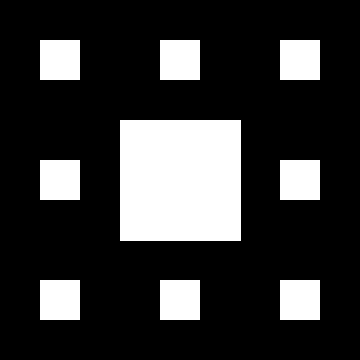

In [13]:
print("Image size: {}x{} pixels.".format(old_width, old_height), Image.BILINEAR)
display(original_image)

In [14]:
%%timeit

for n in range(limitIntValue):
           
    resizer.write(0x00,0x00)
   
    
    # Determine new width and height for resized images
    
    new_width = int(old_width/3)
    new_height = int(old_height/3)

    resizer.write(0x10, old_height)
    resizer.write(0x18, old_width)
    resizer.write(0x20, new_height)
    resizer.write(0x28, new_width)
        
    in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8, cacheable=1)
    out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), dtype=np.uint8, cacheable=1)
    
    in_buffer[:,:,0:3] = np.array(original_image)[:,:,0:3]
      
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.transfer(in_buffer)
    resizer.write(0x00,0x1) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()  
    resizer.write(0x00,0x00) # reset
    
    xlnk.xlnk_reset()
    
    out_buffer.shape
    
    result = Image.fromarray(np.array(out_buffer, dtype=np.uint8))
    np.array(result).shape

    # Box co-ordinate system
    
    box = (0, 0, new_width, new_height)
    box2 = (new_width, 0, 2 * new_width, new_height)
    box3 = (2 * new_width, 0, 3 * new_width, new_height)
    box4 = (0, new_height, new_width, 2 * new_height)
    box5 = (0, 2 * new_height, new_width, 3 * new_height)
    box6 = (new_width, new_height, 2 * new_width, 2 * new_height)
    box7 = (new_width, 2 * new_height, 2 * new_width, 3 * new_height)
    box8 = (2 * new_width, new_height, 3 * new_width, 2 * new_height)
    box9 = (2 * new_width, 2 * new_height, 3 * new_width, 3 * new_height)

    #Paste resized images onto original image
    
    original_image.paste(result, box)
    original_image.paste(result, box2)
    original_image.paste(result, box3)
    original_image.paste(result, box4)
    original_image.paste(result, box5)
    original_image.paste(result, box6)
    original_image.paste(result, box7)
    original_image.paste(result, box8)
    original_image.paste(result, box9)

    d = ImageDraw.Draw(original_image)

    # Fill middle square with white color to hide it
    
    d.rectangle([(new_width, new_height), (2 * new_width, 2 * new_height)], fill=(255, 255, 255, 255)) 

10 loops, best of 3: 74.1 ms per loop


# Refrences

https://github.com/Xilinx/PYNQ-HelloWorld

https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb

https://pillow.readthedocs.io/en/3.1.x/index.html

https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb